In [1]:
import pandas as pd 
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score, f1_score,  precision_recall_fscore_support

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D, Conv1D, Input
from tensorflow.keras import layers

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Helper Functions

In [2]:
def import_embeddings(path):
    """
    Loads embeddings from a text file
    """
    import os 
    path_to_glove_file = os.path.join(
      os.path.expanduser("~"), path
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    return embeddings_index


### For visualizing trainning loss and validation loss
import matplotlib.pyplot as plt 
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  plt.plot(hist['mae'], label='training_mae')
  plt.plot(hist['val_mae'], label = 'validation_mae')
  plt.legend()
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()
  

def make_embedding_matrix(word_index, embedding_dim, embeddings_index):
    """
    Returns embedding matrix
    """
    num_tokens = len(word_index) + 2
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


def compare(X, y_true, y_preds):
  """
  Returns data frame with the test, actual rating, predicited rating, and rounded predicted rating
  """
  return pd.DataFrame({'Text':X, 
                'Actual Rating':y_true, 
                'Predicted Rating':np.squeeze(y_preds),
                'Rounded Rating':np.round(np.squeeze(y_preds))})
  
def get_f1_weighted(compare_df):
  return f1_score(compare_df['Actual Rating'],compare_df['Rounded Rating'], average='weighted')
    


def get_preds(model, X_dev):
  probs = model.predict(X_dev)
  preds = tf.squeeze(tf.round(probs))
  return preds    

def calc_metrics(y_true, y_pred):

 # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_results = {"accuracy": model_accuracy/100,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

  return model_results



# Loading and Cleaning

In [3]:
la = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Los%20Angeles_restaurant.csv")
sd = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Diego_restaurant.csv")
sf = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Francisco_restaurant.csv")
oc = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Orange%20County_restaurant.csv")
at = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Atalanta_restaurant.csv')
ny = pd.read_csv('https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/New%20York_restaurant.csv')

In [4]:
def clean_name(col):
    if 'http' in col:
        col = col.split('Reviews')[1]
        col = col.split('-')[-2]
        col = col.replace('_',' ')
        return col
    else:
        return col



In [5]:
df = pd.concat([la,sd,ny,oc,sf,at])
df['rating'] = df['rating']/10 
df['restaurant'] = df['restaurant'].apply(lambda x: clean_name(x))
df['restaurant'] = df['restaurant'].apply(lambda x: 'In-N-Out Burger' if 'In N Out' in x else x)
df = df[pd.to_numeric(df['review'], errors='coerce').isnull()]
df = df.dropna(subset=['rating','review'])

# Balance dataset 
- Convert Non 5 ratings to 0 and 5 star ratings to 1

In [6]:
df['is_5'] = df['rating'].apply(lambda x: 1 if x==5 else 0)

In [7]:
df['is_5'].value_counts().values[0]/len(df)
## Percentage of 1 in the dataset

0.5527648291090267

In [8]:
df['is_5'].value_counts()

1    585787
0    473953
Name: is_5, dtype: int64

# Splitting Train Test Dev

In [9]:
def train_dev_test_df(df, splits):
    """"
    Takes in a dataframe and splits into train dev and test
    """
    np.random.seed(42)
    shuffle_df = df.sample(frac=1)

    train, dev = splits

    X = shuffle_df['review'].to_numpy()
    y = shuffle_df['is_5'].to_numpy()

    train_cutoff = int(X.shape[0]*train)
    dev_cutoff = int(X.shape[0]*(train+dev))

    X_train = X[:train_cutoff]
    y_train = y[:train_cutoff]

    X_dev = X[train_cutoff:dev_cutoff]
    y_dev = y[train_cutoff:dev_cutoff]

    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]

    y_train = tf.constant(y_train, dtype=tf.int32)
    y_dev = tf.constant(y_dev, dtype = tf.int32)
    y_test = tf.constant(y_test, dtype=tf.int32)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [10]:
train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels = train_dev_test_df(df,(.9,.05))

# Converting to Dataset

In [11]:
# x_train = text_vectorizer(np.array([[s] for s in train_sentences])).numpy()
# x_val = text_vectorizer(np.array([[s] for s in val_sentences])).numpy()

In [12]:
train_data = (tf.data.Dataset.from_tensor_slices(
    (train_sentences,
    train_labels)
))

val_data = (tf.data.Dataset.from_tensor_slices(
    (val_sentences,
    val_labels)
))

In [13]:
batch_size=128
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
train_data_repeat = train_data.repeat()
val_data_repeat = val_data.repeat()

# Models

## Baseline Models: Naives Bayes

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [16]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Results

In [17]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.96%


In [18]:
baseline_preds = model_0.predict(val_sentences)

baseline_metrics = calc_metrics(val_labels, baseline_preds)
baseline_metrics

{'accuracy': 0.7296317964783815,
 'f1': 0.7776639662290096,
 'precision': 0.7121457604957221,
 'recall': 0.8564591665812054}

In [ ]:
print(classification_report(val_labels, baseline_preds))

              precision    recall  f1-score   support

           0       0.76      0.57      0.66     23734
           1       0.71      0.86      0.78     29253

    accuracy                           0.73     52987
   macro avg       0.74      0.71      0.72     52987
weighted avg       0.74      0.73      0.72     52987



## Deep Models 
---
 - Need to find the Avg and St dev for the amount of words per review

### No pretrain embeddings 

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

True

In [ ]:
def train():
  hyperparamters_defaults = dict(epochs=3,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='LSTM',
                                embed_dim = 128,
                                max_vocab_length=50000)

  run = wandb.init(project='food_nlp_sweep_1',
                  config = hyperparamters_defaults)

  config = wandb.config

  embedding = Embedding(input_dim=config.max_vocab_length,
                        output_dim=config.embed_dim,
                        embeddings_initializer='uniform',
                        input_length = max_length)

  inputs = Input(shape=(1,), dtype='string')

  x = text_vectorizer(inputs)

  x = embedding(x)
  x = Bidirectional(LSTM(64))(x) 
  x = Dropout(config.dropout_rate)(x)

  outputs = Dense(1, activation="sigmoid")(x)

  model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM")
  model_1.summary()

  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model_1.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
                  metrics=METRICS)
  
  model_1.fit(train_data,
              epochs=config.epochs,
              steps_per_epoch=len(train_data),
              validation_data=val_data,
              validation_steps=int(0.15*len(val_data)),
              callbacks = [WandbCallback(save_weights_only=True)])

  model_1_preds = get_preds(model_1, val_sentences)
  model_1_metrics = calc_metrics(val_labels, model_1_preds)

  wandb.log(model_1_metrics)

  

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'learning_rate': {
            'values': np.logspace(-1,-5, num=10).tolist()
        },
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6, 0.8]
        }
    }
}

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_2')        

Create sweep with ID: 2gcn07qh
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_2/sweeps/2gcn07qh


In [ ]:
wandb.agent(sweep_id, function=train)

### Pretrained Embeddings 

In [26]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-15 16:19:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-15 16:19:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-15 16:19:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [22]:
train_sentences_lengths = pd.Series([len(i.split()) for i in train_sentences])

max_length = int(train_sentences_lengths.mean() + train_sentences_lengths.std())
max_vocab_length = 70000

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_sentences)


In [23]:
voc = text_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [27]:
embeddings_100 = import_embeddings('/content/glove.6B.100d.txt')
embeddings_200 = import_embeddings('/content/glove.6B.200d.txt')
embeddings_300 = import_embeddings('/content/glove.6B.300d.txt')


## makes embedding matrix with token vectors
embedding_matrix_100 = make_embedding_matrix(word_index,100, embeddings_100)
embedding_matrix_200 = make_embedding_matrix(word_index,200, embeddings_200)
embedding_matrix_300 = make_embedding_matrix(word_index,300, embeddings_300)


Found 400000 word vectors.
Found 400000 word vectors.
Found 400000 word vectors.
Converted 38079 words (31921 misses)
Converted 38079 words (31921 misses)
Converted 38079 words (31921 misses)


#### LSTM

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'learning_rate': {
            'values': np.logspace(-2,-4, num=5).tolist()
        },
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6, 0.8]
        },
          'dense_units': {
            'values' : [8, 32, 64, 128, 256]
          },
          'embed_dim': {
              'values' : [100,200,300]
          }
    }
}

In [ ]:
def train_lstm():
  hyperparamters_defaults = dict(epochs=9,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='LSTM',
                                max_vocab_length=70000)

  run = wandb.init(project='food_nlp_sweep_1',
                  config = hyperparamters_defaults)


  config = wandb.config

  ## for sweep to select embedding 
  embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
  embedding_matrix = embedding_dic[config.embed_dim]

  max_vocab, embed_dim = embedding_matrix.shape

  embedding = Embedding(max_vocab,
                      embed_dim,
                      tf.keras.initializers.Constant(embedding_matrix),
                      trainable=False)

  inputs = Input(shape=(1,), dtype='string')
  x = text_vectorizer(inputs)

  x = embedding(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
  x = Bidirectional(LSTM(64))(x) 
  x = Dropout(config.dropout_rate)(x)
  x = Dense(config.dense_units, activation='relu')(x)
  x = Dropout(config.dropout_rate)(x)
  outputs = Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
                  metrics=METRICS)
    
  model.summary()

  model.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
            epochs=config.epochs,
            steps_per_epoch=int(0.2*len(train_data)),
            validation_data = val_data_repeat,
            validation_steps = int(0.2*len(val_data)),
            callbacks=[WandbCallback()])

  model.fit(train_data,
            steps_per_epoch=len(train_data))

  model_preds = get_preds(model, val_data)
  metrics = calc_metrics(val_labels, model_preds)

  wandb.log(metrics)

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_3')        

Create sweep with ID: vvpkvg0a
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_3/sweeps/vvpkvg0a


##### Training

In [ ]:
wandb.agent('vvpkvg0a',  project='food_nlp_sweep_3' ,function=train_lstm)

#### CONV1D

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
         'dropout_rate': {
            'values' : [0.2, 0.4, 0.6]
        },
          'dense_units': {
            'values' : [64, 128, 256]
          },
          'kernel_size': {
              'values' : [3,5]
          },
            'filters': {
              'values' : [8,32,64,128,256]
          },
          'pool_size': {
              'values' : [3,5]
          }
    }
}

In [ ]:
def train_conv1d():  
  hyperparamters_defaults = dict(epochs=9,
                                batch_size=batch_size,
                                optimizer='adam',
                                loss_function='binary_crossentropy',
                                architecture='CONV1D',
                                max_vocab_length=70000,
                                embedding_dimension=300,
                                 learning_rate=0.001)

  run = wandb.init(project='food_nlp_sweep_4',
                  config = hyperparamters_defaults)


  config = wandb.config

  max_vocab, embed_dim = embedding_matrix_300.shape

  embedding = Embedding(max_vocab,
                      embed_dim,
                      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix_300),
                      trainable=False)

  inputs = Input(shape=(1,), dtype='string')

  x = text_vectorizer(inputs)

  x = embedding(x)
  x = layers.Conv1D(config.filters, config.kernel_size, activation="relu")(x)
  x = layers.MaxPooling1D(config.pool_size)(x)

  x = layers.Conv1D(config.filters, config.kernel_size, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)

  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(config.dropout_rate)(x)

  outputs = Dense(1, activation="sigmoid")(x)

  model_conv = tf.keras.Model(inputs, outputs, name="model_CONV1D")


  METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')] 

  model_conv.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=METRICS)
    
  model_conv.summary()

  model_conv.fit(train_data_repeat,
                            epochs = config.epochs,
                            steps_per_epoch=int(0.2*len(train_data)),
                            validation_data = val_data_repeat,
                            validation_steps = int(0.2*len(val_data)),
                            callbacks=[WandbCallback()])

  model_conv.fit(train_data,
                steps_per_epoch=len(train_data))

  model_conv_preds = get_preds(model_conv, val_data)
  metrics = calc_metrics(val_labels, model_conv_preds)

  wandb.log(metrics)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='food_nlp_sweep_4')        

Create sweep with ID: k8e32ghs
Sweep URL: https://wandb.ai/jacobh0830/food_nlp_sweep_4/sweeps/k8e32ghs


##### Training

In [ ]:
wandb.agent(sweep_id, function=train_conv1d)

# Best Models from hyperparamter sweeps

## LSTM

In [ ]:
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS)
  
model.summary()

model.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
          epochs=8,
          steps_per_epoch=int(0.2*len(train_data)),
          validation_data = val_data_repeat,
          validation_steps = int(0.2*len(val_data)))

model.fit(train_data,
          steps_per_epoch=len(train_data))

# Fine Tuning 

## Conv1D

In [ ]:
max_vocab, embed_dim = embedding_matrix_300.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix_300),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')

x = text_vectorizer(inputs)

x = embedding(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)

x = layers.Conv1D(128, 5 , activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.6)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_conv = tf.keras.Model(inputs, outputs, name="model_CONV1D")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=METRICS)
  
model_conv.summary()

model_conv.fit(train_data_repeat,
                          epochs = 8,
                          steps_per_epoch=int(0.2*len(train_data)),
                          validation_data = val_data_repeat,
                          validation_steps = int(0.2*len(val_data)))

model_conv.fit(train_data,
              steps_per_epoch=len(train_data))



In [ ]:
  model_conv_preds_prefinetune = get_preds(model_conv, val_data)
  metrics_conv_prefinetune = calc_metrics(val_labels, model_conv_preds_prefinetune)
  metrics_conv_prefinetune

{'accuracy': 0.7631683243059618,
 'f1': 0.7992770197859851,
 'precision': 0.751067155654422,
 'recall': 0.8541004341435067}

In [ ]:
model_conv.save_weights('conv_weights')
# model_conv.load_weights('conv_weights')

In [ ]:
embedding.trainable = True

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

### Callbacks 

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)

checkpoint_path = "20k_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
finetune_epochs = 5

history_model_conv_fintune = model_conv.fit(train_data_repeat,
                                          epochs = finetune_epochs,
                                          steps_per_epoch=int(0.2*len(train_data)),
                                          validation_data = val_data_repeat,
                                          validation_steps = int(0.2*len(val_data)),)
                                          # callbacks=[reduce_lr, early_stopping, model_checkpoint])

Epoch 1/5
1490/1490 [==============================] - 171s 114ms/step - loss: 0.4530 - accuracy: 0.7724 - precision: 0.7667 - recall: 0.8457 - val_loss: 0.4772 - val_accuracy: 0.7660 - val_precision: 0.7613 - val_recall: 0.8386
Epoch 2/5
1490/1490 [==============================] - 169s 113ms/step - loss: 0.4423 - accuracy: 0.7861 - precision: 0.7806 - recall: 0.8522 - val_loss: 0.4780 - val_accuracy: 0.7664 - val_precision: 0.7684 - val_recall: 0.8250
Epoch 3/5
1490/1490 [==============================] - 169s 113ms/step - loss: 0.4315 - accuracy: 0.7926 - precision: 0.7875 - recall: 0.8573 - val_loss: 0.4801 - val_accuracy: 0.7673 - val_precision: 0.7650 - val_recall: 0.8345
Epoch 4/5
1490/1490 [==============================] - 163s 109ms/step - loss: 0.4371 - accuracy: 0.7883 - precision: 0.7836 - recall: 0.8508 - val_loss: 0.4758 - val_accuracy: 0.7663 - val_precision: 0.7685 - val_recall: 0.8246
Epoch 5/5
1490/1490 [==============================] - 159s 107ms/step - loss: 0.420

In [ ]:
model_conv_preds_post_finetune = get_preds(model_conv, val_data)
metrics_conv_post_finetine = calc_metrics(val_labels, model_conv_preds_post_finetune)
metrics_conv_post_finetine

{'accuracy': 0.7682639137901749,
 'f1': 0.8012881717993948,
 'precision': 0.7608174554394591,
 'recall': 0.8463063617406762}

## LSTM

In [ ]:
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.6)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs, name="model_1_LSTM")


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS)
  
model.summary()

model.fit(train_data_repeat,    ## repeat data set required when the steps per epoch does not equal the total number of batches
          epochs=8,
          steps_per_epoch=int(0.2*len(train_data)),
          validation_data = val_data_repeat,
          validation_steps = int(0.2*len(val_data)))

model.fit(train_data,
          steps_per_epoch=len(train_data))

Model: "model_1_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_3 (TextVe (None, 60)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 60, 300)           30000600  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 60, 128)           186880    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                

In [ ]:
  
model.fit(train_data,
              steps_per_epoch=len(train_data))


model_lstm_preds_prefinetune = get_preds(model, val_data)
metrics_lstm_prefinetune = calc_metrics(val_labels, model_conv_preds_prefinetune)
metrics_lstm_prefinetune

7452/7452 [==============================] - 159s 21ms/step - loss: 0.4987 - accuracy: 0.7573 - precision: 0.7309 - recall: 0.8880


{'accuracy': 0.7631683243059618,
 'f1': 0.7992770197859851,
 'precision': 0.751067155654422,
 'recall': 0.8541004341435067}

In [ ]:
embedding.trainable = True

model_conv.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=METRICS)

history_model_lstm_fintune = model_conv.fit(train_data_repeat,
                                          epochs = finetune_epochs,
                                          steps_per_epoch=int(0.2*len(train_data)),
                                          validation_data = val_data_repeat,
                                          validation_steps = int(0.2*len(val_data)),)

Epoch 1/5
1490/1490 [==============================] - 219s 146ms/step - loss: 0.4258 - accuracy: 0.7638 - precision: 0.7396 - recall: 0.8841 - val_loss: 0.4792 - val_accuracy: 0.7663 - val_precision: 0.7596 - val_recall: 0.8430
Epoch 2/5
1490/1490 [==============================] - 216s 145ms/step - loss: 0.4144 - accuracy: 0.8017 - precision: 0.7949 - recall: 0.8641 - val_loss: 0.4837 - val_accuracy: 0.7663 - val_precision: 0.7671 - val_recall: 0.8274
Epoch 3/5
1490/1490 [==============================] - 237s 159ms/step - loss: 0.4045 - accuracy: 0.8085 - precision: 0.8023 - recall: 0.8687 - val_loss: 0.4896 - val_accuracy: 0.7662 - val_precision: 0.7607 - val_recall: 0.8404
Epoch 4/5
1490/1490 [==============================] - 247s 166ms/step - loss: 0.4139 - accuracy: 0.8012 - precision: 0.7940 - recall: 0.8634 - val_loss: 0.4833 - val_accuracy: 0.7659 - val_precision: 0.7713 - val_recall: 0.8181
Epoch 5/5
1490/1490 [==============================] - 246s 165ms/step - loss: 0.399

# Hybrid

In [33]:
! pip install vaderSentiment

     |████████████████████████████████| 133kB 7.8MB/s 


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()



In [35]:
train_sents = [analyzer.polarity_scores(train_sentences[i]) for i in range(len(train_sentences))]
val_sents = [analyzer.polarity_scores(val_sentences[i]) for i in range(len(val_sentences))]

In [36]:
train_sents_df = pd.DataFrame(train_sents).astype('float32')
val_sents_df = pd.DataFrame(val_sents).astype('float32')

In [37]:
train_sents_data = tf.data.Dataset.from_tensor_slices((train_sents_df.drop(columns='compound'), train_labels))
val_sents_data = tf.data.Dataset.from_tensor_slices((val_sents_df.drop(columns='compound'), val_labels))

In [38]:
batch_size=128
train_sents_data = train_sents_data.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_sents_data = val_sents_data.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

## Combining Data

In [39]:
batch_size = 128

train_combined_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_sents_df.drop(columns='compound')))
train_combined_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_combined_dataset =   tf.data.Dataset.zip((train_combined_data, train_combined_labels))
train_combined_dataset = train_combined_dataset.shuffle(buffer_size=1000).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


val_combined_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_sents_df.drop(columns='compound')))
val_combined_labels = tf.data.Dataset.from_tensor_slices(val_labels)
val_combined_dataset =   tf.data.Dataset.zip((val_combined_data, val_combined_labels))
val_combined_dataset = val_combined_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [40]:
train_combined_dataset_repeat = train_combined_dataset.repeat()
val_combined_dataset_repeat = val_combined_dataset.repeat()

In [41]:
# lstm model
embedding_dic = {100:embedding_matrix_100, 200:embedding_matrix_200, 300:embedding_matrix_300}
embedding_matrix = embedding_dic[300]

max_vocab, embed_dim = embedding_matrix.shape

embedding = Embedding(max_vocab,
                    embed_dim,
                    tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False)

lstm_inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(lstm_inputs)

x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x) 
x = Bidirectional(LSTM(64))(x) 
x = Dropout(0.6)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.6)(x)

lstm_model = tf.keras.Model(inputs=lstm_inputs,
                            outputs =x)


# vader sentiment model
sent_inputs = Input(shape=(3,), dtype=tf.float32, name='input_layer')
x = Dense(32, activation='relu')(sent_inputs)
x = Dense(16, activation='relu')(x)
model_sents = tf.keras.Model(inputs= sent_inputs,
                             outputs=x)
## Cocatenate

sent_lstm_concat = layers.Concatenate(name='concat_layer')([lstm_model.output, model_sents.output])
concat_output = Dense(1, activation='sigmoid')(sent_lstm_concat)

sent_lstm_model = tf.keras.Model(inputs=[lstm_model.input, model_sents.input],
                                 outputs=concat_output)

sent_lstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 60)           0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      21000600    text_vectorization_1[1][0]       
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 128)      186880      embedding_1[0][0]                
____________________________________________________________________________________________

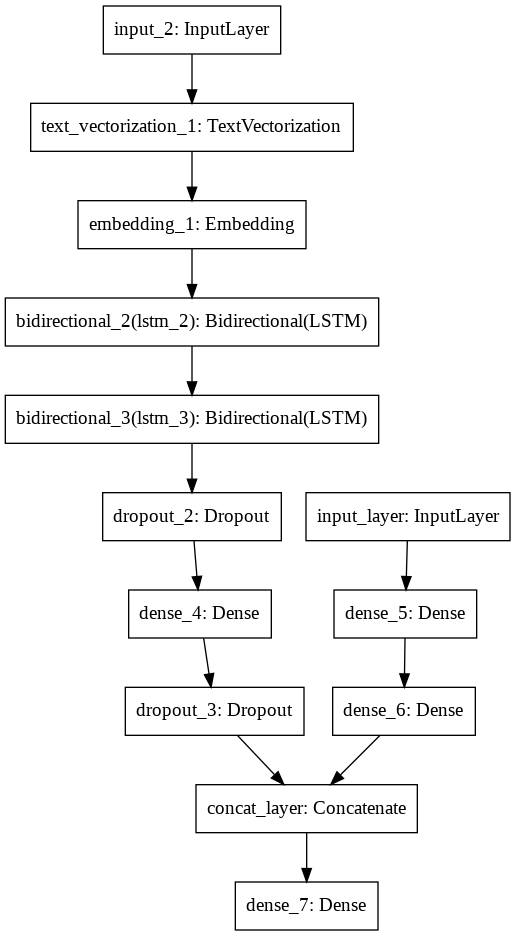

In [42]:
from tensorflow.keras.utils import plot_model
plot_model(sent_lstm_model)

In [43]:
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')] 

sent_lstm_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=METRICS)

In [44]:
sent_lstm_model.fit(train_combined_dataset_repeat, 
                    epochs=10,
                    steps_per_epoch=int(0.2*len(train_combined_dataset)),
                    validation_data=val_combined_dataset_repeat,
                    validation_steps=int(0.2*len(val_combined_dataset)))

Epoch 1/10
1490/1490 [==============================] - 43s 23ms/step - loss: 0.5839 - accuracy: 0.6898 - precision: 0.6932 - recall: 0.7894 - val_loss: 0.5302 - val_accuracy: 0.7273 - val_precision: 0.7111 - val_recall: 0.8516
Epoch 2/10
1490/1490 [==============================] - 33s 22ms/step - loss: 0.5521 - accuracy: 0.7157 - precision: 0.7120 - recall: 0.8151 - val_loss: 0.5175 - val_accuracy: 0.7379 - val_precision: 0.7331 - val_recall: 0.8250
Epoch 3/10
1490/1490 [==============================] - 33s 22ms/step - loss: 0.5406 - accuracy: 0.7235 - precision: 0.7176 - recall: 0.8265 - val_loss: 0.5117 - val_accuracy: 0.7375 - val_precision: 0.7073 - val_recall: 0.8939
Epoch 4/10
1490/1490 [==============================] - 33s 22ms/step - loss: 0.5327 - accuracy: 0.7290 - precision: 0.7220 - recall: 0.8262 - val_loss: 0.5012 - val_accuracy: 0.7547 - val_precision: 0.7549 - val_recall: 0.8220
Epoch 5/10
1490/1490 [==============================] - 33s 22ms/step - loss: 0.5267 - a

In [45]:
hybrid_model_preds = get_preds(sent_lstm_model, val_combined_dataset)
hybrid_results = calc_metrics(val_labels, hybrid_model_preds)
hybrid_results

{'accuracy': 0.7649234717949686,
 'f1': 0.8060356909277772,
 'precision': 0.7401973401973402,
 'recall': 0.8847297713055071}